In [1]:
import pandas as pd
import re
import nltk
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

   ENTITY_ID  CATEGORY_ID  ENTITY_LENGTH  \
0     216064          112     600.000000   
1    2498090         8360     984.251967   
2     210860           30     850.000000   
3     285757         6104     744.000000   
4    1869643         2201     600.000000   

                                  ENTITY_DESCRIPTION  
0                               Caricaturas (1892)    
1  VJ Interior Modern Solid Interio Cushioned Bar...  
2  Pam: Personalized Name Journal with Blank Line...  
3  Hio Nya Testamenti Drottins Vors Jesu Krists A...  
4  ADDIT Phone Case for Samsung Galaxy A50 [ Mili...  
Missing values:
 ENTITY_ID             0
CATEGORY_ID           0
ENTITY_LENGTH         0
ENTITY_DESCRIPTION    0
dtype: int64
          ENTITY_ID    CATEGORY_ID  ENTITY_LENGTH
count  1.000000e+05  100000.000000  100000.000000
mean   1.481478e+06    3992.661350     846.074230
std    8.694148e+05    3969.245926     667.183486
min    2.200000e+01       0.000000       1.000000
25%    7.209542e+05     222.0

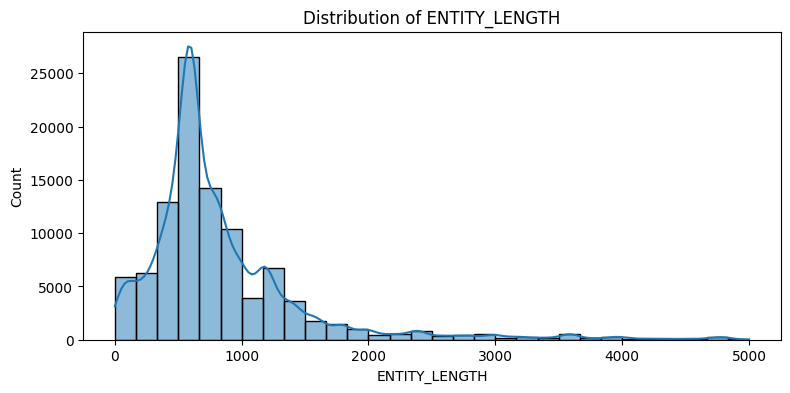

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Login_Datathon/Train.csv")

print(df.head())

print("Missing values:\n", df.isnull().sum())

print(df.describe())

plt.figure(figsize=(9, 4))
sns.histplot(df['ENTITY_LENGTH'], kde=True, bins=30)
plt.title('Distribution of ENTITY_LENGTH')
plt.show()

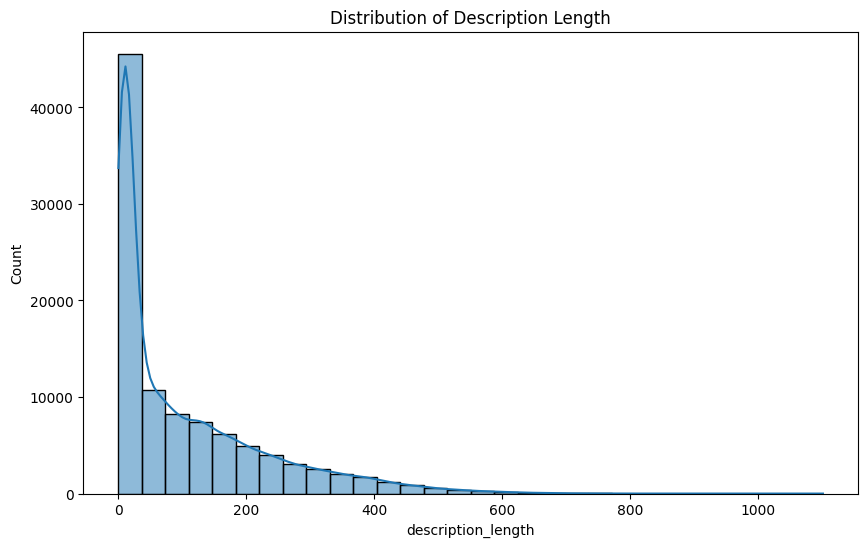

In [3]:
df.fillna(df.select_dtypes(include=np.number).median(), inplace=True)
df['ENTITY_DESCRIPTION'].fillna('', inplace=True)

# Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# Preprocessing: Remove punctuation, convert to lowercase, remove stopwords, lemmatization, and stemming
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [stemmer.stem(lemmatizer.lemmatize(word)) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['cleaned_description'] = df['ENTITY_DESCRIPTION'].apply(preprocess_text)

df['description_length'] = df['ENTITY_DESCRIPTION'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(df['description_length'], kde=True, bins=30)
plt.title('Distribution of Description Length')
plt.show()

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


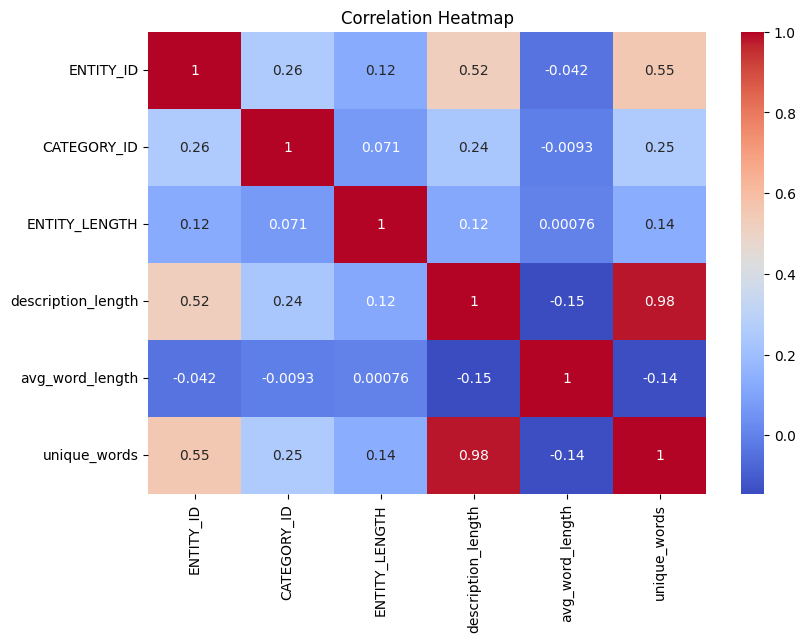

In [4]:
df['avg_word_length'] = df['ENTITY_DESCRIPTION'].apply(lambda x: np.mean([len(word) for word in x.split()]) if x else 0)

df['unique_words'] = df['ENTITY_DESCRIPTION'].apply(lambda x: len(set(x.split())))

numeric_cols = df.select_dtypes(include=np.number).columns
plt.figure(figsize=(9, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

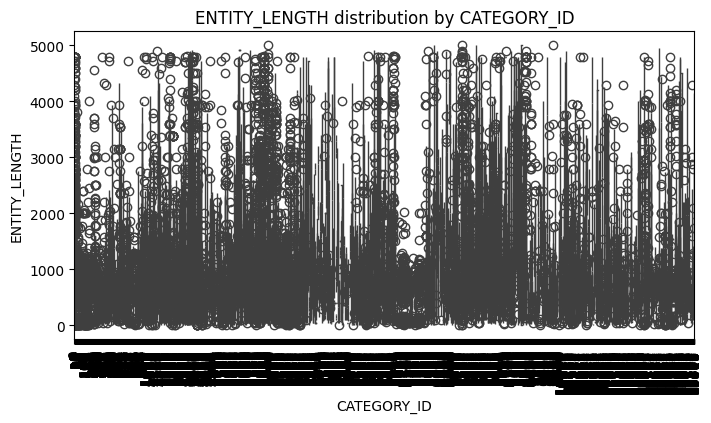

In [5]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='CATEGORY_ID', y='ENTITY_LENGTH', data=df)
plt.title('ENTITY_LENGTH distribution by CATEGORY_ID')
plt.xticks(rotation=90)
plt.show()

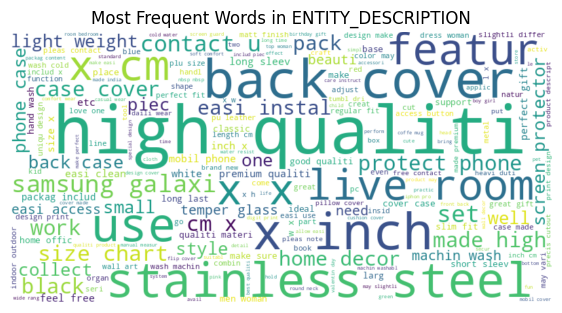

In [6]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_description']))
plt.figure(figsize=(7, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in ENTITY_DESCRIPTION')
plt.show()

In [ ]:
all_words = ' '.join(df['cleaned_description']).split()
word_freq = Counter(all_words)
print("Most common words:", word_freq.most_common(10))

most_frequent_words = [word for word, freq in word_freq.most_common(5)]
rare_words = [word for word, freq in word_freq.items() if freq < 2]

def remove_words(text):
    tokens = text.split()
    tokens = [word for word in tokens if word not in most_frequent_words and word not in rare_words]
    return ' '.join(tokens)

df['cleaned_description'] = df['cleaned_description'].apply(remove_words)

Most common words: [('design', 56412), ('use', 45605), ('x', 41566), ('size', 40896), ('cover', 37949), ('case', 36202), ('qualiti', 35108), ('made', 33059), ('color', 32851), ('protect', 31339)]


In [ ]:
encoder = OneHotEncoder(sparse=False)
category_encoded = encoder.fit_transform(df[['CATEGORY_ID']])
category_df = pd.DataFrame(category_encoded, columns=encoder.get_feature_names_out(['CATEGORY_ID']))
df = pd.concat([df, category_df], axis=1)
df.drop(columns=['CATEGORY_ID'], inplace=True)

In [ ]:
tfidf = TfidfVectorizer(ngram_range=(1, 2), max_features=500)  # Using unigrams and bigrams
tfidf_matrix = tfidf.fit_transform(df['cleaned_description'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
df = pd.concat([df, tfidf_df], axis=1)

df.drop(columns=['ENTITY_DESCRIPTION', 'cleaned_description'], inplace=True)

X = df.drop(columns=['ENTITY_LENGTH', 'ENTITY_ID'])  # Features
y = df['ENTITY_LENGTH']  # Target

scaler = StandardScaler()
X = scaler.fit_transform(X)

print("Data shape:", X.shape)
print("Sample data:\n", df.head())
